# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64

from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL

In [4]:
%run "Git.ipynb".ipynb

In [5]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [8]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [15]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [16]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_140280\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [17]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [18]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [19]:
holding=Binance.get_inventory()

In [20]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,4349.65,1.00,-131.89,2164.71,2032.82
OMUSDT,526.32,2948.83,0.68,0.00,2422.51,2422.51
BTCUSDT,601.02,743.14,0.17,3.54,142.12,145.66
SOLUSDT,281.20,226.35,0.05,0.00,-54.85,-54.85
JASMYUSDT,387.46,164.77,0.04,0.00,-222.69,-222.69
ETHUSDT,250.75,136.40,0.03,0.00,-114.35,-114.35
TRXUSDT,76.87,114.70,0.03,-10.72,37.83,27.11
BBUSDT,60.18,14.38,0.00,-39.73,-45.80,-85.53
BNBUSDT,1.14,1.08,0.00,-10.61,-0.06,-10.67
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [21]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

476

In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: de9a3f500e5187bf0128c75dd90d613ac5d98797)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 234cecec7bc0a38ea6de0335ecfa1ffbcd6912a0)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [42]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [43]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-03-16    2210.019473
2025-03-17    2353.886859
2025-03-18    2355.780860
2025-03-19    2369.599362
2025-03-20    2311.994731
Name: Total, Length: 179, dtype: float64

In [44]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-03-16      7.249559
2025-03-17    143.867386
2025-03-18      1.894001
2025-03-19     13.818502
2025-03-20    -57.604631
Name: Total, Length: 179, dtype: float64

In [45]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,5)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-217.91282855557566, -334.9272908594338)

In [46]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [47]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [48]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [49]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [50]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [51]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [52]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

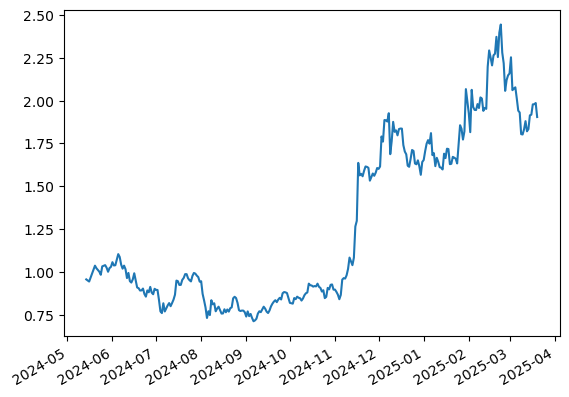

In [53]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

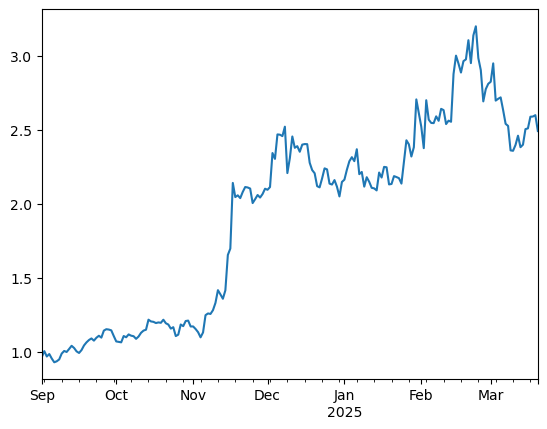

In [54]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [56]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [59]:
days=30
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [60]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [63]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.6395
OMUSDT,0.2258
AAVEUSDT,0.1325
DEXEUSDT,0.0023
BNBUSDT,0.0000
WLDUSDT,0.0000
INJUSDT,0.0000
BONKUSDT,0.0000
LDOUSDT,0.0000
ARBUSDT,0.0000


In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.471499
BTCUSDT,0.300000
OMUSDT,0.228501


In [65]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

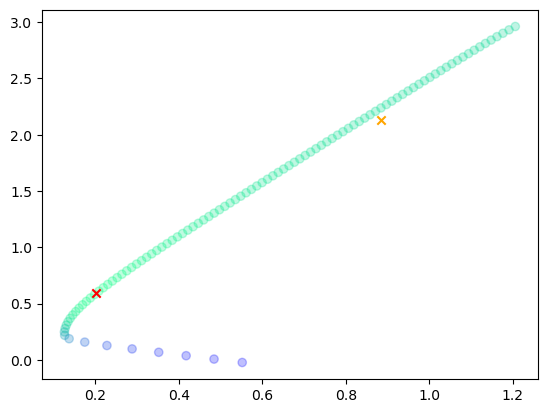

In [66]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [67]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [68]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2948.827112,0.677946,0.0636,0.614346
BTCUSDT,743.144768,0.170852,0.0000,0.170852
SOLUSDT,226.347817,0.052038,0.0000,0.052038
JASMYUSDT,164.772575,0.037882,0.0000,0.037882
ETHUSDT,136.398468,0.031358,0.0000,0.031358
TRXUSDT,114.697267,0.026369,0.0053,0.021069
BBUSDT,14.376906,0.003305,0.0000,0.003305
BNBUSDT,1.084456,0.000249,0.0714,-0.071151
PEPEUSDT,0.000002,0.000000,0.0045,-0.004500
PAXGUSDT,0.000000,0.000000,0.3958,-0.395800


### Current results

In [70]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [71]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.876426
OMUSDT,0.102311
TRXUSDT,0.021263


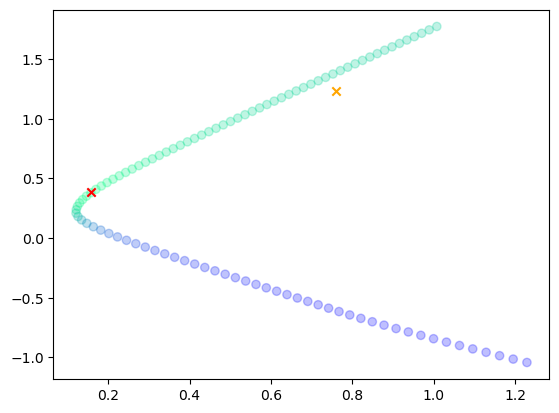

In [72]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [73]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2948.827112,0.677946,0.102311,0.575635
BTCUSDT,743.144768,0.170852,0.000000,0.170852
SOLUSDT,226.347817,0.052038,0.000000,0.052038
JASMYUSDT,164.772575,0.037882,0.000000,0.037882
ETHUSDT,136.398468,0.031358,0.000000,0.031358
TRXUSDT,114.697267,0.026369,0.021263,0.005106
BBUSDT,14.376906,0.003305,0.000000,0.003305
BNBUSDT,1.084456,0.000249,0.000000,0.000249
PEPEUSDT,0.000002,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.876426,-0.876426


# Risk Reward Analysis

In [75]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [76]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

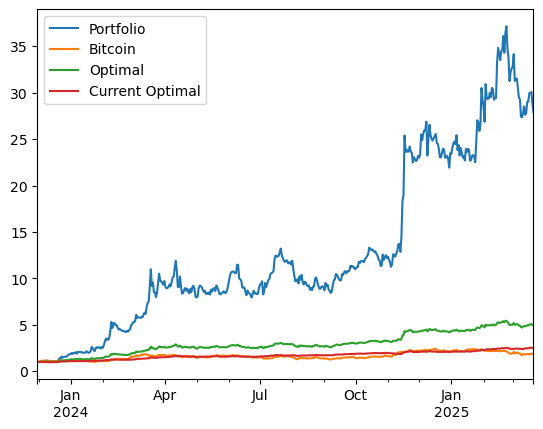

In [77]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [78]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

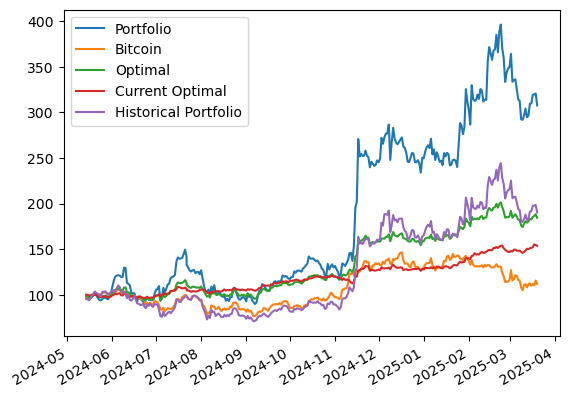

In [79]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [80]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-03-11,296.695564,110.822138,178.095462,147.177772,183.215484
2025-03-12,304.273202,111.816046,180.551490,148.622237,187.971314
2025-03-13,294.723724,108.335893,179.145408,150.654081,182.047066
2025-03-14,296.584579,112.099402,180.434950,150.161226,183.335317
2025-03-15,309.438075,112.572571,183.179637,151.285753,191.350939
2025-03-16,309.820279,110.193184,182.838969,151.413236,191.748673
2025-03-17,319.421446,112.092354,185.543379,152.530137,197.754476
2025-03-18,319.598637,110.351014,186.493174,155.302006,197.858229
2025-03-19,320.732229,115.728906,188.384430,154.801926,198.556312
2025-03-20,307.605515,112.180303,184.560905,153.839661,190.373258


## Volatilities

In [82]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.350792
 dtype: float64,
 0.3511506575998467)

In [83]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.760171
 dtype: float64,
 0.7601712887364153)

In [84]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.885336
Bitcoin            0.434338
Optimal            0.351151
Current Optimal    0.175165
dtype: float64

In [85]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4690476007900604

In [86]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-2.105814098024455

In [87]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.6235808815852906

## Risk Contribution

In [89]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.258950,0.300000,0.030651,0.236864,0.137693,0.099171
OMUSDT,16.751409,0.228501,0.931130,0.716286,0.616255,0.100031
PAXGUSDT,0.225460,0.471499,0.038219,0.046850,0.029871,0.016979


In [90]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.413369,0.102311,0.306649,0.473704,0.419630,0.054075
TRXUSDT,0.007788,0.021263,0.017275,0.028373,0.010918,0.017455
PAXGUSDT,0.260507,0.876426,0.676076,0.497922,0.455490,0.042432


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,2.747415,0.68,0.918240,0.884771,0.812009,0.072762
BTCUSDT,0.033718,0.17,0.054578,0.046265,0.008749,0.037515
SOLUSDT,-0.019380,0.05,0.008203,0.024873,0.002345,0.022527
JASMYUSDT,-0.026407,0.04,0.003642,0.025969,0.003340,0.022629
ETHUSDT,-0.013743,0.03,0.004355,0.009601,0.000522,0.009080
TRXUSDT,0.010988,0.03,0.010981,0.008521,0.000952,0.007569


# Value At Risk

## Historical

### Optimal Weights

In [95]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.02804730023545866, -0.039686436916963816)

### Current Weights

In [97]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05545470462149796, -0.08090776426196716)

In [98]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [99]:
var=historical_var.iloc[row]
var

OMUSDT      -0.037248
BTCUSDT     -0.005032
SOLUSDT     -0.002286
JASMYUSDT   -0.005135
ETHUSDT     -0.002485
TRXUSDT     -0.002402
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.054588
Name: 2025-02-02 00:00:00, dtype: float64

In [100]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.063295
BTCUSDT     -0.006040
SOLUSDT     -0.003596
JASMYUSDT   -0.003653
ETHUSDT     -0.001746
TRXUSDT     -0.001028
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.079360
dtype: float64

## Parametric

### Optimal Weights

In [103]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.0363848402495983, -0.04663530534880341)

### Current Weights

In [105]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.07876593793688458, -0.10095615485935973)

## Multivariate

### Optimal Weights

In [108]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03321893950155894, -0.041835717711854854)

### Current Weights

In [110]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07319133996843667, -0.09359352848771038)

In [111]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

OMUSDT      -0.065585
BTCUSDT     -0.003205
SOLUSDT     -0.002080
JASMYUSDT   -0.002013
ETHUSDT     -0.000611
TRXUSDT     -0.000610
Portfolio   -0.074104
dtype: float64

In [112]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

OMUSDT      -0.067687
BTCUSDT     -0.002659
SOLUSDT     -0.001845
JASMYUSDT   -0.001771
ETHUSDT     -0.000650
TRXUSDT     -0.000376
Portfolio   -0.074987
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [116]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03366534677927264, -0.04344026092504751)

### Current Weights

In [118]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07311974900690857, -0.0928866070113487)

In [119]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [122]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.032985085789349, -0.042383714995498735)

### Current Weights

In [124]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07490606380954268, -0.09543796567240483)

In [125]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [128]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06751530973154027, -0.09251906677395455)

### Current Weights

In [130]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.15298116244974228, -0.2190901864952712)

In [131]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [134]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [135]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.037486952308824706, -0.04713163113324103)

### Current Weights

In [137]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08125115435885288, -0.10042437269046084)

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [139]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.152513,-0.066365,-0.071382,-0.065585,-0.064172
BTCUSDT,-0.000884,-0.002916,-0.003832,-0.003205,-0.003840
SOLUSDT,-0.000160,-0.001759,-0.001899,-0.002080,-0.002229
JASMYUSDT,-0.000544,-0.001639,-0.001922,-0.002013,-0.002648
ETHUSDT,-0.000145,-0.000603,-0.000699,-0.000611,-0.000929
TRXUSDT,0.000364,-0.000357,-0.000677,-0.000610,-0.000862
Portfolio,-0.153883,-0.073638,-0.080411,-0.074104,-0.074680


In [140]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.155160,-0.066749,-0.072724,-0.067687,-0.063794
BTCUSDT,-0.000423,-0.003120,-0.003379,-0.002659,-0.004465
SOLUSDT,-0.000374,-0.001812,-0.001840,-0.001845,-0.002430
JASMYUSDT,0.000005,-0.001732,-0.002016,-0.001771,-0.002815
ETHUSDT,-0.000079,-0.000638,-0.000620,-0.000650,-0.001041
TRXUSDT,-0.000095,-0.000387,-0.000789,-0.000376,-0.001023
Portfolio,-0.156125,-0.074438,-0.081368,-0.074987,-0.075568


## VaR Violation

In [142]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.028811,-0.053592,-0.045197,-0.011783
2024-01-15,-0.028811,-0.053599,-0.044957,0.012398
2024-01-16,-0.028811,-0.053650,-0.046266,0.024569
2024-01-17,-0.028811,-0.055013,-0.045919,-0.019686
2024-01-18,-0.028811,-0.055903,-0.049230,-0.015475
...,...,...,...,...
2025-03-17,-0.038621,-0.043096,-0.044363,0.014791
2025-03-18,-0.038621,-0.043029,-0.045610,0.005119
2025-03-19,-0.038621,-0.043249,-0.044417,0.010141
2025-03-20,-0.038621,-0.043366,-0.045714,-0.020296


In [143]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.044762,-0.083333,-0.083381,-0.014994
2024-05-29,-0.044762,-0.081264,-0.080868,-0.007107
2024-05-30,-0.044762,-0.071546,-0.071592,0.025376
2024-05-31,-0.044762,-0.075514,-0.072518,0.048170
2024-06-01,-0.044762,-0.082165,-0.078057,0.065759
...,...,...,...,...
2025-03-17,-0.081311,-0.081871,-0.092604,0.030989
2025-03-18,-0.060590,-0.065732,-0.068718,0.000555
2025-03-19,-0.060590,-0.065665,-0.070612,0.003547
2025-03-20,-0.061422,-0.069415,-0.074602,-0.040927


<Axes: >

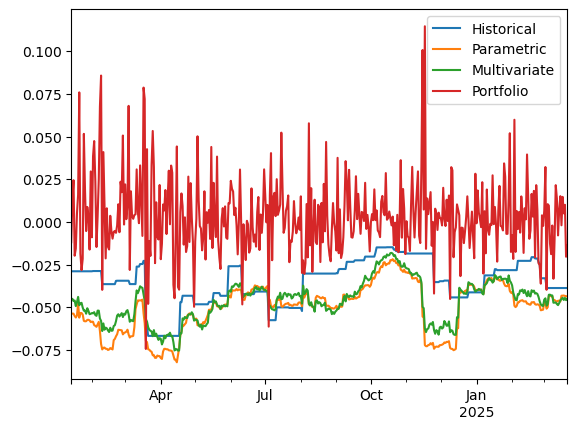

In [144]:
var_data.plot()

<Axes: >

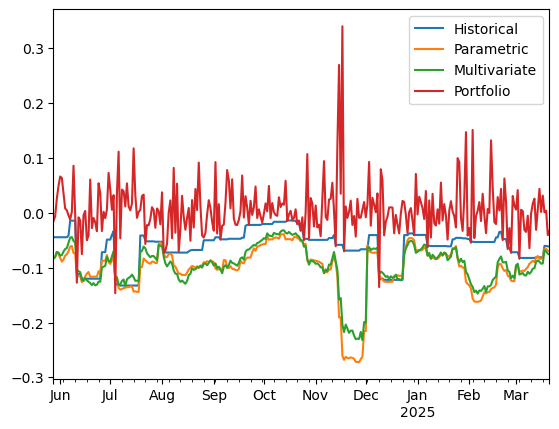

In [145]:
current_var_data.plot()

In [146]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.032333,0.006928,0.006928
Kupiec Stat,3.234848,26.274708,26.274708
P-value,0.072087,0.0,0.0


In [147]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.063758,0.013423,0.010067
Kupiec Stat,1.096622,11.693855,14.676853
P-value,0.295009,0.000627,0.000128


# Principal Component Analysis

## Historical PCA

In [150]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.8079626 , 0.05775179, 0.0508126 , 0.04766587, 0.03580715])

In [151]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.018082
ADAUSDT      0.019491
ALGOUSDT     0.020559
APTUSDT      0.018145
ARBUSDT      0.019814
ATOMUSDT     0.017891
AVAXUSDT     0.020033
BCHUSDT      0.015955
BNBUSDT      0.009298
BONKUSDT     0.024600
BTCUSDT      0.010176
CAKEUSDT     0.018605
DEXEUSDT     0.013993
DOGEUSDT     0.019291
DOTUSDT      0.018435
EOSUSDT      0.018718
ETCUSDT      0.016824
ETHUSDT      0.013884
FDUSDUSDT    0.000052
FETUSDT      0.023596
FILUSDT      0.020319
FLOWUSDT     0.019687
GRTUSDT      0.022113
HBARUSDT     0.019455
ICPUSDT      0.018306
IMXUSDT      0.020491
INJUSDT      0.021522
IOTAUSDT     0.021753
JASMYUSDT    0.021849
LDOUSDT      0.021212
LINKUSDT     0.018281
LTCUSDT      0.013664
MKRUSDT      0.013363
NEARUSDT     0.022112
NEXOUSDT     0.011847
OMUSDT       0.011250
OPUSDT       0.020404
PAXGUSDT     0.000281
PEPEUSDT     0.024987
QNTUSDT      0.015956
SANDUSDT     0.021930
SEIUSDT      0.021784
SHIBUSDT     0.018780
SOLUSDT      0.016950
STXUSDT      0.021501
SUIUSDT   

<Axes: >

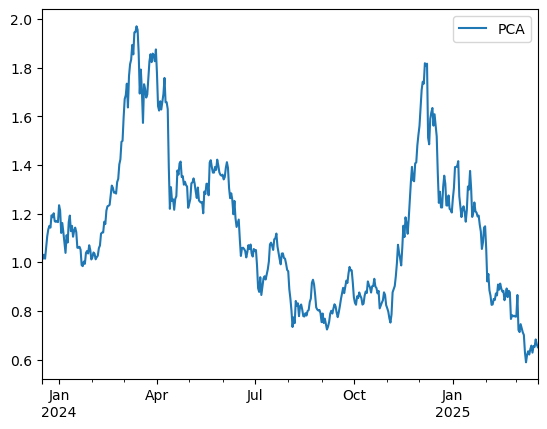

In [152]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

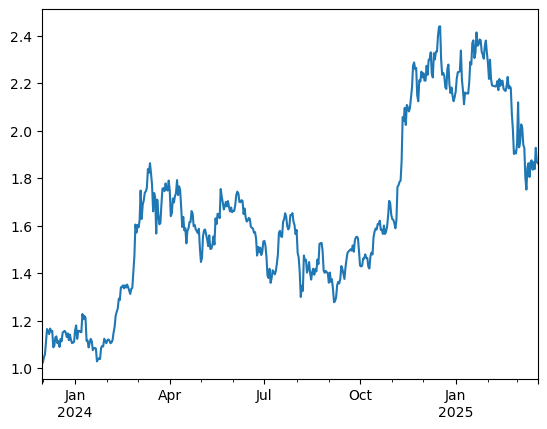

In [153]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [154]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.431019
WBETHUSDT    0.456433
ETHUSDT      0.456832
ATOMUSDT     0.477201
DOTUSDT      0.480807
ETCUSDT      0.487520
NEXOUSDT     0.509841
WBTCUSDT     0.545303
BTCUSDT      0.545346
AVAXUSDT     0.546642
EOSUSDT      0.549573
FILUSDT      0.567653
IOTAUSDT     0.569994
ARBUSDT      0.580879
XTZUSDT      0.584547
GRTUSDT      0.585541
LINKUSDT     0.611401
VETUSDT      0.614314
ALGOUSDT     0.623476
dtype: float64

<Axes: >

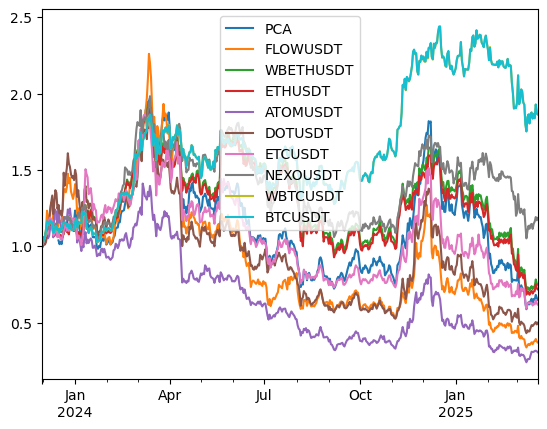

In [155]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

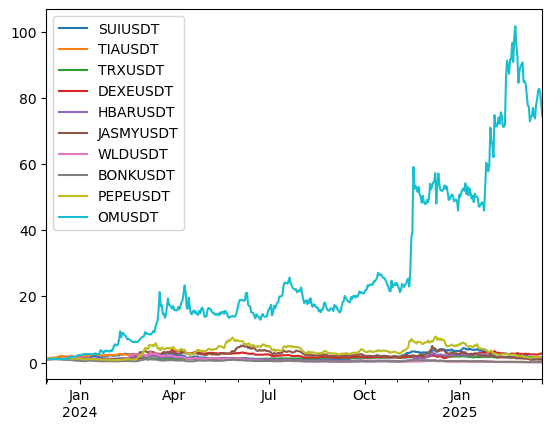

In [156]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [158]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59661861, 0.14093769, 0.10861588, 0.088265  , 0.06556283])

In [159]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.088363
BTCUSDT      0.061497
SOLUSDT      0.108641
JASMYUSDT    0.173019
ETHUSDT      0.089442
TRXUSDT      0.050732
BBUSDT       0.197560
BNBUSDT      0.065280
PEPEUSDT     0.162515
PAXGUSDT     0.002951
Name: PC1, dtype: float64

<Axes: >

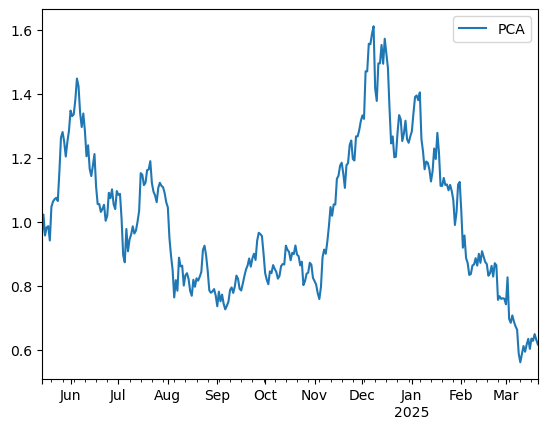

In [160]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

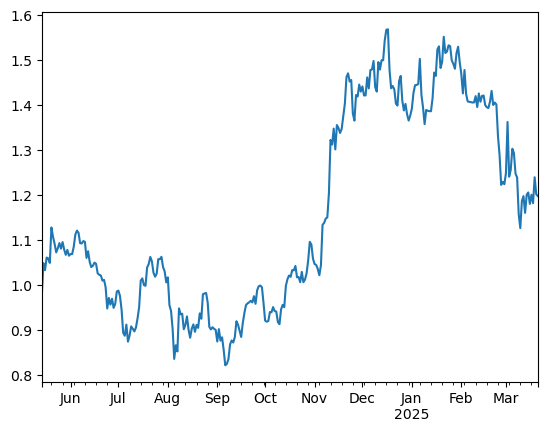

In [161]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [162]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.450785
BNBUSDT      0.511544
BTCUSDT      0.515655
SOLUSDT      0.529558
JASMYUSDT    0.708721
PEPEUSDT     0.762602
PAXGUSDT     0.782495
BBUSDT       0.807822
TRXUSDT      0.951717
dtype: float64

<Axes: >

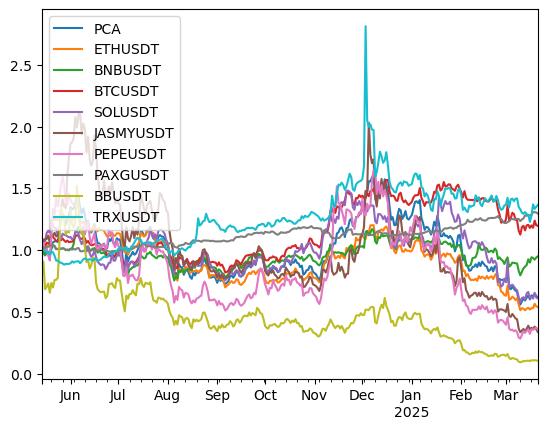

In [163]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [165]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.863801
BBUSDT       1.571818
JASMYUSDT    1.379791
SOLUSDT      1.244763
ETHUSDT      1.014388
BTCUSDT      1.000000
OMUSDT       0.868752
BNBUSDT      0.659660
TRXUSDT      0.331534
PAXGUSDT     0.037240
Name: BTCUSDT, dtype: float64

In [166]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT      1.843600
JASMYUSDT    1.570238
PEPEUSDT     1.518853
BBUSDT       1.334891
ETHUSDT      1.302837
BTCUSDT      1.000000
BNBUSDT      0.595409
OMUSDT       0.578710
TRXUSDT      0.335062
PAXGUSDT     0.024099
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [168]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [169]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BNBUSDT,0.187229
BBUSDT,0.177400
JASMYUSDT,0.174651
ETHUSDT,0.161835
BTCUSDT,0.158242
SOLUSDT,0.135806
TRXUSDT,0.056559
PEPEUSDT,0.047397
OMUSDT,-0.049412
PAXGUSDT,-0.063399


### Regression to PCA

In [171]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.1012887857216291

In [172]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.289591
BNBUSDT      1.147386
PCA          1.000000
ETHUSDT      0.993886
PAXGUSDT     0.756635
SOLUSDT      0.704566
JASMYUSDT    0.467881
PEPEUSDT     0.436148
BBUSDT       0.406731
TRXUSDT      0.281522
OMUSDT       0.249328
dtype: float64

In [173]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.338423
BTCUSDT      1.304944
PCA          1.000000
ETHUSDT      0.949388
TRXUSDT      0.880019
JASMYUSDT    0.760138
BBUSDT       0.689150
OMUSDT       0.683348
PEPEUSDT     0.652976
SOLUSDT      0.646247
PAXGUSDT     0.221179
dtype: float64

### Correlation Matrix

<Axes: >

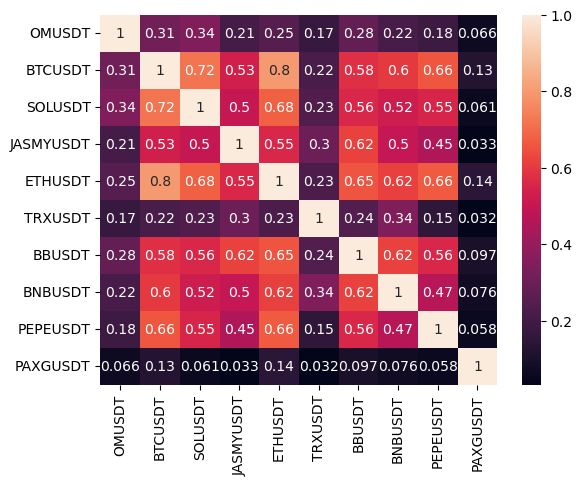

In [175]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

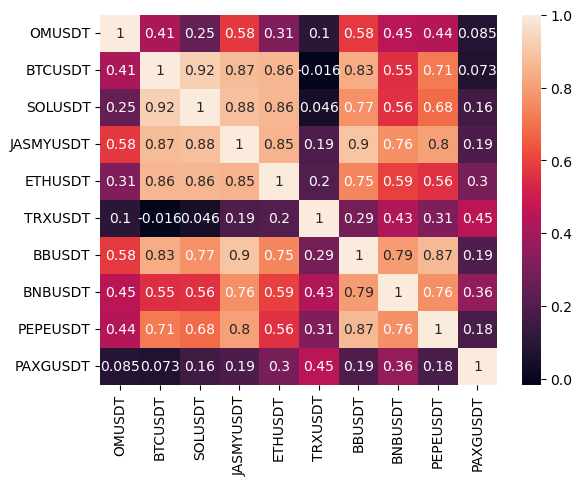

In [176]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [178]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.626168,0.000000,0.000000,0.150876,0.000000,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.019283,0.260704,0.086231,0.000000,0.000000,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.435186,0.000000,0.000000,0.000000,0.000000,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.176734,0.000000,0.000000,0.000000,0.166022,0.526886,0.000000,0.000000,0.130357,0.000000


In [179]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-08-13,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.503993,0.0
2024-09-12,0.419444,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.305683,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-10-12,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.152999,0.020386,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-11-11,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-12-11,0.159765,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.037828,0.226258,0.0
2025-01-10,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-02-09,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-03-11,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-03-21,0.134894,0.0,0.0,0.0,0.0,0.025807,0.0,0.0,0.276613,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [180]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

DEXEUSDT    0.363687
BNBUSDT     0.276613
AAVEUSDT    0.134894
SHIBUSDT    0.123256
CAKEUSDT    0.075743
ATOMUSDT    0.025807
Name: 2025-03-21 00:00:00, dtype: float64

In [181]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
